# Demonstration of Ensemble generalization score vs an Individual Classifier

In [1]:
from scipy.special import comb
import math

def ensemble_error(n_classifier : int, error : float) -> float | int :

    ''' 
        Calculates the error of an ensemble classifier. An assumption
        is made that the ensemble's classifiers have equal error rates,
        are independent of one another, and the errors are not correlated.

        This function demonstrates the total error of the model when 
        n_classifer / 2 to n_classifiers miscalculate the class label.
        In otherwords, the worst case scenario when an ensemble would
        misclassify a lable using majority voting.

        @param n_classifier: number of classifiers in the ensemble model
        @param error       : error rate of each classifier in the model
    '''

    def instance_error(k : int, n_classifiers : int, error : float) -> float | int :
        ''' 
            Calculate the probability of an ensemble model producing an error
            given the total classifiers that produced misclassifications, the 
            error rate of each classifier, and the error for each classifer.

            This is calculated as the binomial mass function of a binomial distribution.
            
            @param k: total classfiers that misclassified the data
            @param n_classifers: total classifiers in the ensemble
            @param error       : error rate of each classifier
        '''

        return comb(n_classifier,k) * (error**k) * ((1-error)**(n_classifier - k))
    

    k_start = int(math.ceil(n_classifier / 2.))
    probs = [instance_error(k,n_classifier,error) for k in range(k_start,n_classifier+1)]
    return sum(probs)

ensemble_error(n_classifier=11, error= .25)

0.03432750701904297

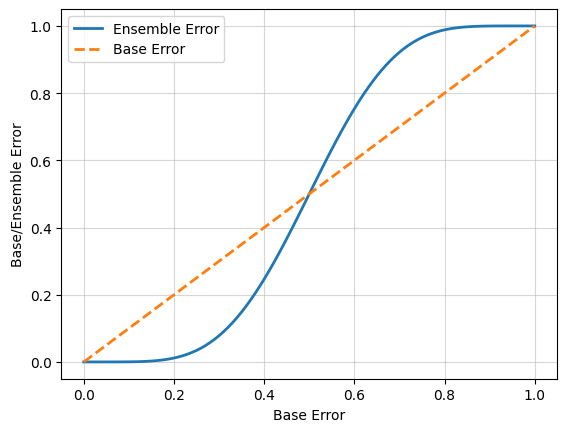

In [2]:
import numpy as np
import matplotlib.pyplot as plt

'''
    The error probability of an ensemble is always better than that of an individual classifier as long as the base classifiers
    perform better than random guessing.
'''
error_range = np.arange(0.,1.01,.01)
ensemble_errors = [ensemble_error(n_classifier=11,error=e) for e in error_range]

''' Plot our error for an ensemble classifier'''
plt.plot(
    error_range,
    ensemble_errors,
    linewidth=2,
    label='Ensemble Error'
)

''' Plot our error for a single classifier '''
plt.plot(
    error_range,
    error_range,
    linestyle='--',
    label='Base Error',
    linewidth=2
)

plt.xlabel('Base Error')
plt.ylabel('Base/Ensemble Error')

plt.legend(loc='upper left')

plt.grid(alpha=.5)

plt.show()

# Demonstration of Majority Vote by label and probability

In [3]:
def majority_vote_by_label(labels : list[int], weights : list[int | float] = None) -> int :
    ''' 
        Calculates the predicted label based on the mode, with consideration to weights if defined
        @param labels             : list of class labels as predicted by the ensemble classifer
        @param weights [optional] : weights to assign to predictions by each classifier
    '''
    return np.argmax(np.bincount(labels, weights=weights))

majority_vote_by_label(labels = [0,0,1], weights=[.2,.2,.6])

1

In [4]:
def majority_vote_by_probability(probabilities : list[list[int]], weights : list[int | float] = None) -> int :
    '''
        Calculates the predicted label of an ensemble based on class membership probabilities, with 
        consideration to weights if defined, by using the max weighted average for each class membership
        along axis 0 and taking the max average.

        Each probability list in probabilities should be [class 0 proba, class 1 proba]
        and should add up to 1.

        @param probabilites       : class membership probabilites, 2D array
        @param weights [optional] : weights to assign to probabilities by each classifier
    '''
    weighted_avg = np.average(probabilities, weights=weights, axis=0)
    return np.argmax(weighted_avg)

majority_vote_by_probability(
    probabilities= [
        [.9,.1],
        [.8,.2],
        [.4,.6]
    ],
    weights=[.2,.2,.6]
)

0

# Building a Majority Vote Classifier

In [10]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

In [11]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

In [12]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [13]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


## Tuning the Classifier